In [1]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import keras
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# ffmpeg -i "2020-01-28 04-25-57.mp4" -filter:v "crop=54:14:894:208,select=not(mod(n\,5))" -vsync vfr 1_every_5/img_%06d.jpg
score_rect = [894, 208, 948, 222]

Using TensorFlow backend.


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


KeyboardInterrupt: 

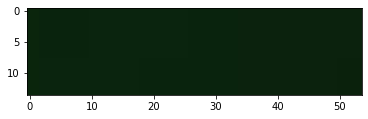

In [4]:
from score_recognition import get_score, crop_score, get_digit_frames
import cv2
import matplotlib.pyplot as plt

cap = cv2.VideoCapture(r"S:/Wormax/data/nn2/2020-06-22 14-03-31.flv")

ret = True
for j in range(10000):
    ret, frame = cap.read()
    frame = frame / 255
    if j % 100 != 0:
        continue
    
    plt.figure()
    plt.imshow(crop_score(frame))
    plt.title(get_score(frame))
        
    plt.figure()
    for i in range(6):
        plt.subplot(1, 6, i + 1)
        plt.imshow(get_digit_frames(crop_score(frame))[i])
    
    plt.show()

In [5]:
import keras
import cv2
import numpy as np
from joblib import load

score_rect = [894, 208, 948, 222]
digits_classifier = keras.models.load_model('SVHN_classifier.hdf5')

In [1]:
from score_recognition import get_score, crop_score
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

cap = cv2.VideoCapture(r"D:\Wormax\data\nn\2020-01-28 04-25-57.mp4")

ret = True
score = []
for j in tqdm_notebook(range(10000000)):
    ret, frame = cap.read()
    frame = frame / 255
    score.append(get_score(frame))

Using TensorFlow backend.
W0129 10:15:57.600311  7500 module_wrapper.py:137] From C:\Users\lmura\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0129 10:15:58.680700  7500 module_wrapper.py:137] From C:\Users\lmura\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0129 10:15:58.791433  7500 deprecation.py:506] From C:\Users\lmura\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0129 10:15:59.343953  7500 module_wrapper.py:137] From C:\Users\lm

KeyboardInterrupt: 

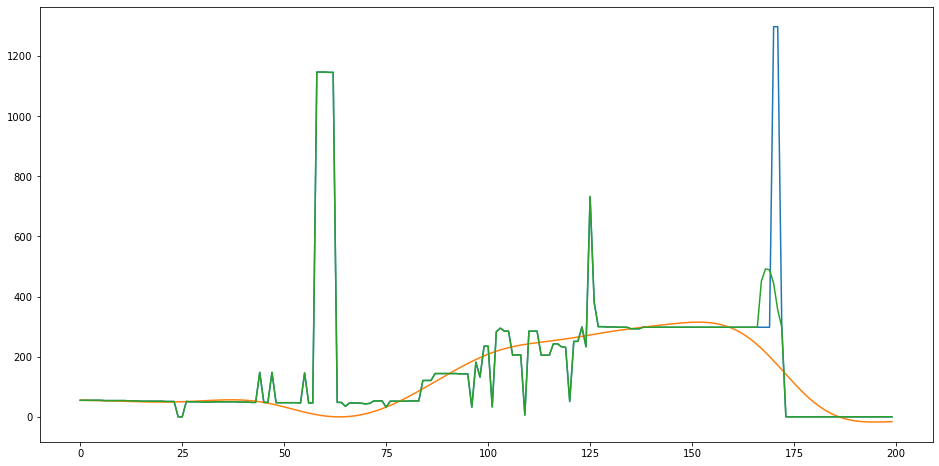

In [13]:
%matplotlib inline
import numpy as np
from scipy import signal


def filter_score(score):
    
    b, a = signal.butter(3, 0.05)
    y = signal.filtfilt(b, a, score)
    score[np.abs(score - y) > 100] = 0
    score_filtered = []
    prev = 0
    for i in score:
        score_filtered.append(prev if i == 0 else i)
        prev = i
    return signal.filtfilt(b, a,score_filtered)

def despike(yi,th=50):
    '''Remove spike from array yi, the spike area is where the difference between 
    the neigboring points is higher than th.'''
    y = np.copy(yi) # use y = y1 if it is OK to modify input array
    n = len(y)
    x = np.arange(n)
    c = np.argmax(y)
    d = abs(np.diff(y))
    try:
        l = c - 1 - np.where(d[c-1::-1]<th)[0][0]
        r = c + np.where(d[c:]<th)[0][0] + 1
    except: # no spike, return unaltered array
        return y
    # for fit, use area twice wider then the spike
    if (r-l) <= 3:
        l -= 1
        r += 1
    s = int(round((r-l)/2.))
    lx = l - s
    rx = r + s
    # make a gap at spike area
    xgapped = np.concatenate((x[lx:l],x[r:rx]))
    ygapped = np.concatenate((y[lx:l],y[r:rx]))
    # quadratic fit of the gapped array
    z = np.polyfit(xgapped,ygapped,2)
    p = np.poly1d(z)
    y[l:r] = p(x[l:r])
    return y
def filter_score2(score):
    return despike(score)
# def filter_score2(score):
#     score_filtered = [0]
#     for i in score:
#         score_filtered.append(score_filtered[-1] if np.abs(i - np.median(score_filtered[-5:])) > 200 else i)
#     return score_filtered

def plot(score):
    score = np.array(score)
    for i in range(1, len(score)):
        score[i] = score[i - 1] if score[i] > 3000 else score[i]

    score_filtered = filter_score(score.copy())
    score_filtered2 = filter_score2(score.copy())

    plt.figure(figsize=(16, 8))
    plt.plot(np.arange(len(score)), score)
    plt.plot(np.arange(len(score_filtered)), score_filtered)
    plt.plot(np.arange(len(score_filtered2)), score_filtered2)
    plt.savefig('fig.jpg')
    plt.show()

# plot(score[3510:3523])
plot(score[1000:1200])
# plot(score)
# interact(f, x=1000)

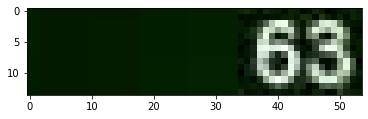

In [150]:
for i in range(100):
    ret, frame = cap.read()
frame = frame / 255

plt.figure()
img = crop_score(frame)
plt.imshow(img)

In [10]:
import os
import imageio
from score_recognition import get_score_from_crop, crop_score
from tqdm import tqdm_notebook

path_images = r'S:\Wormax\data\nn\1_every_5_image'
path_scores = r'S:\Wormax\data\nn\1_every_5'


def generator_helper():
    while True:
        for score_path in sorted(os.listdir(path_scores)):
            yield imageio.imread(os.path.join(path_scores, score_path))
            
gen = generator_helper()    
score = []   
for i in tqdm_notebook(range(10000)):
    img = next(gen)
    img = img / 255
    score.append(get_score_from_crop(img))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


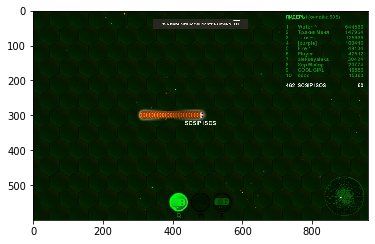

In [7]:
cap = cv2.VideoCapture(r"D:\Wormax\data\nn\2020-01-28 04-25-57.mp4")

for j in range(30*5-5):
    ret, frame = cap.read()
plt.imshow(frame)

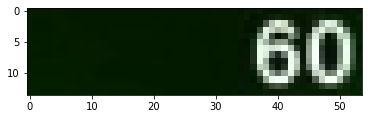

In [8]:
plt.imshow(crop_score(frame))

In [9]:
plt.imsave('f.jpg', crop_score(frame))

# view death

In [14]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import imageio

path = r'D:\Wormax\data\nn\1_every_5_image'

def generator():
    for img_path in sorted(os.listdir(path)):
        yield imageio.imread(os.path.join(path, img_path))

shift = 1000
        
gen = generator()
# for i in range(shift):
#     next(gen)

im = plt.imshow(next(gen))

score_filtered = filter_score(score).round()

prev = 0
def animate(i):
    global prev
    img = next(gen)
    im.set_data(img)
#     plt.gcf().suptitle(f'{np.abs(img[:20].sum().astype(np.int32) - prev) == 0} {i}')
#     plt.gcf().suptitle(f'{score[i + shift]} {score_filtered[i + shift]}')
    prev = img[:20].sum()

anim = animation.FuncAnimation(plt.gcf(), animate, interval=10)

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: 'D:\\Wormax\\data\\nn\\1_every_5_image'

In [113]:
next(gen).sum() == prev


False

In [7]:
plt.plot([1, 2], [1, 2])

Traceback (most recent call last):
  File "C:\Miniconda3\lib\site-packages\matplotlib\backends\backend_qt5.py", line 505, in _draw_idle
    self.draw()
  File "C:\Miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py", line 388, in draw
    self.figure.draw(self.renderer)
  File "C:\Miniconda3\lib\site-packages\matplotlib\artist.py", line 38, in draw_wrapper
    return draw(artist, renderer, *args, **kwargs)
  File "C:\Miniconda3\lib\site-packages\matplotlib\figure.py", line 1709, in draw
    renderer, self, artists, self.suppressComposite)
  File "C:\Miniconda3\lib\site-packages\matplotlib\image.py", line 135, in _draw_list_compositing_images
    a.draw(renderer)
  File "C:\Miniconda3\lib\site-packages\matplotlib\artist.py", line 38, in draw_wrapper
    return draw(artist, renderer, *args, **kwargs)
  File "C:\Miniconda3\lib\site-packages\matplotlib\axes\_base.py", line 2647, in draw
    mimage._draw_list_compositing_images(renderer, self, artists)
  File "C:\Miniconda3\lib\

In [1]:
import cv2
import numpy as np

cap = cv2.VideoCapture(r"S:\Wormax\data\nn\2020-01-28 04-25-57.mp4")
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frameCount = 30*60*5
buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

fc = 0
ret = True

while (fc < frameCount  and ret):
    ret, buf[fc] = cap.read()
    fc += 1

cap.release()

cv2.waitKey(0)

-1

In [2]:
import sys
sys.getsizeof(buf)/2**30

14.483928814530373

In [3]:
buf.shape

(9000, 600, 960, 3)

In [15]:
from score_recognition import get_score_from_crop, crop_score
import cv2
from tqdm import tqdm_notebook

np.astype(buf, np.float32)
sum = np.zeros_like(crop_score(buf))
for i in tqdm_notebook(range(10000)):
    sum = sum + crop_score(buf[i])
#     cv2.imshow('frame 10', )

#     cv2.waitKey(1)

AttributeError: module 'numpy' has no attribute 'astype'

In [14]:
from score_recognition import get_score, crop_score, get_digit_frames
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

cap = cv2.VideoCapture(r"S:\Wormax\data\nn\resized.mp4")

ret = True
for j in tqdm_notebook(range(10000)):
    ret, frame = cap.read()
    frame = frame / 255
    if not ret:
        break
    
#     plt.figure()
#     cv2.imshow('1', crop_score(frame))
#     cv2.waitKey(1)
    #     plt.title(get_score(frame))
        
    
#     plt.show()

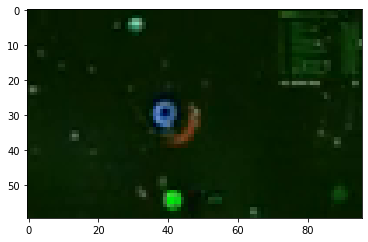

In [16]:
plt.imshow(frame)

In [13]:
import os
import imageio
from score_recognition import get_score_from_crop, crop_score
from tqdm import tqdm_notebook

path_images = r'S:\Wormax\data\nn\1_every_5_image'
path_scores = r'S:\Wormax\data\nn\1_every_5'


def generator_helper():
    while True:
        for image_path in sorted(os.listdir(path_images)):
            yield imageio.imread(os.path.join(path_images, image_path))
            
gen = generator_helper()
score = []   
for i in tqdm_notebook(range(10000)):
    img = next(gen)
    img = img / 255
#     score.append(get_score_from_crop(img))

KeyboardInterrupt: 